# An Introduction to Image Blending
This notebook is an introduction to image blending using Gaussian and Laplacian stacks. Unlike Gaussian and Laplacian pyramids, the images are all at the same size in the stack for simpler processing.

Created by J. van Saders | Tangibit Studios | 2022

In [115]:
# imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.exposure as exposure
from skimage.draw import ellipse

# original image from Wikipedia
MONA_LISA = "mona-lisa-C2RMF-retouched.jpg"

# Theory

For simplicity, only grayscale images will be used. Processing color images is similar; the same operations are applied to each RGB channel.

The flow diagram below shows how Gaussian and Laplacian image stacks are generated from an image. The lowpass filters are implemented by 2D Gaussian functions. They are multiplied with the Fourier transform of the image to create a filtered spectrum. This spectrum is then transformed back into an image. The Laplacian stack images contain information in spatial frequency bands. Note that Laplacian stack images can have negative pixel values due to the subtraction operation that generates them.

![stacks](01-gaussian-laplacian-stacks.png)

The orginal image can be reconstructed by summing the Laplacian image stack.

![reconstruction](01a-reconstruction.png)

A Laplacian stack can be modified by applying a spatial mask normalized to 1 which has been turned into a Gaussian image stack. Each Laplacian image in the stack can also be weight by an overall factor between 0 and 1.

![modified-laplacian](02-modified-laplacian—stack.png)

Image blending uses a combination of modified Laplacian stacks from two images as shown below. For clarity, the stacks are represented as a set, as are the weights.

![img-blending](03-image-blending.png)



# Functions

In [116]:
#-----------------------------------------------------------------------------
def read_img(fname):
    img = cv2.imread(fname)
    img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2RGB)

    return img


#-----------------------------------------------------------------------------
def img2uint8(data):
    # Get min & max value
    minV = np.min(data)
    maxV = np.max(data)
    
    # normalize the data to 0 - 1
    data = (data-minV) / (maxV-minV)
    
    # Now scale by 255
    data = 255 * data 
    
    return data.astype(np.uint8)

#-----------------------------------------------------------------------------
# sample values from a spherical gaussian function from the center of the image
def makeGaussianFilter(numRows, numCols, sigma, highPass=True):
    ctrY = int(numRows/2) + 1 if numRows % 2 == 1 else int(numRows/2)
    ctrX = int(numCols/2) + 1 if numCols % 2 == 1 else int(numCols/2)
    Y, X = np.mgrid[0:numRows, 0:numCols]
    imgFilter = np.exp(-1.0 * ((X - ctrX)**2 + (Y - ctrY)**2) / (2 * sigma**2))

    return 1 - imgFilter if highPass else imgFilter


#-----------------------------------------------------------------------------
def filterDFT(imageMatrix, filterMatrix):
    shiftedDFT = np.fft.fftshift(np.fft.fft2(imageMatrix))
    filteredDFT = shiftedDFT * filterMatrix

    return np.fft.ifft2(np.fft.ifftshift(filteredDFT))


#-----------------------------------------------------------------------------
def lowPass(imageMatrix, sigma):
    n,m = imageMatrix.shape
    
    return filterDFT(imageMatrix, makeGaussianFilter(n, m, sigma, highPass=False))


#-----------------------------------------------------------------------------
def highPass(imageMatrix, sigma):
    n,m = imageMatrix.shape
    
    return filterDFT(imageMatrix, makeGaussianFilter(n, m, sigma, highPass=True))


#-----------------------------------------------------------------------------
def stackGaussian(img, sigmas):

    gaussStack = []

    # full image
    gaussStack.append(img.astype(float))

    # LPF images
    for sigma in sigmas:
        imgLPF = lowPass(img, sigma)
        gaussStack.append(imgLPF.real)


    return np.array(gaussStack)


#-----------------------------------------------------------------------------
def stackLaplacian(img, sigmas):

    laplaceStack = []

    # create gaussian stack
    gaussStack = stackGaussian(img, sigmas)

    # create difference images
    for i, sigma in enumerate(sigmas):
        imgHPF = gaussStack[i] - gaussStack[i+1]
        laplaceStack.append(imgHPF)

    # last stack is most LPF'd image
    laplaceStack.append(gaussStack[-1])

    return np.array(laplaceStack)


#-----------------------------------------------------------------------------
def img_blend(imgA, imgB, mask, wA, wB, sigmas):
    imgAL  = stackLaplacian(imgA, sigmas)
    imgBL  = stackLaplacian(imgB, sigmas)
    maskG  = stackGaussian(mask, sigmas)
    imgC = np.zeros((imgA.shape[0], imgA.shape[1]))
    N    = len(sigmas)+1
    for i in range(0, N):
        imgC += wA[i]*maskG[i]*imgAL[i] + wB[i]*(1-maskG[i])*imgBL[i]
    
    return imgC



# Gaussian filters

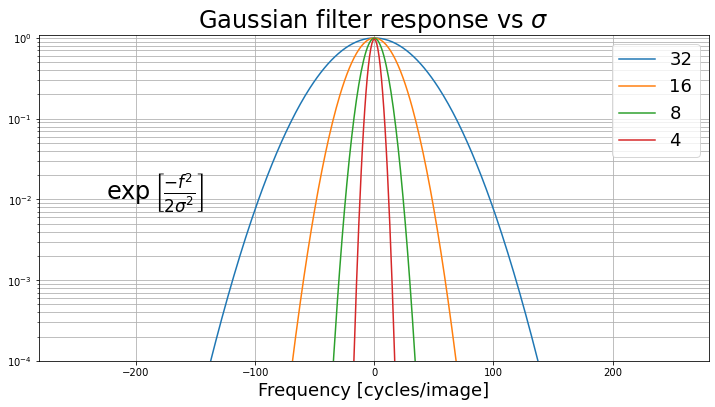

In [117]:
sigmas  = [32, 16, 8, 4]
numRows = 1
numCols = 512
GaussianLPFs = []
for i in range(0, 4):
    GaussianLPF = makeGaussianFilter(numRows, numCols, sigmas[i], highPass=False)
    GaussianLPFs.append(GaussianLPF[0, :])
    
fig, ax = plt.subplots(figsize=(12,6))
freq = range(-256, 256, 1)
for i in range(0, 4):
    ax.plot(freq, GaussianLPFs[i], label=sigmas[i])
    ax.set_xlabel('Frequency [cycles/image]', fontsize=18)

ax.legend(fontsize=18)
ax.set_title('Gaussian filter response vs $\sigma$', fontsize=24)
ax.text(-225, 0.01, r'$\exp{\left[\frac{-f^2}{2 \sigma^2}\right]}$', fontsize=24)
ax.set_yscale('log')
ax.set_ylim(0.0001, 1.1)
ax.grid(which='both')
plt.show()

# The images

**Racoon**
Photo by <a href="https://unsplash.com/@viramedio?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Chris Ensminger</a> on <a href="https://unsplash.com/s/photos/racoon?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  
![racoon](racoon.png)

**Background** Photo by <a href="https://unsplash.com/@trommelkopf?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Steve Harvey</a> on <a href="https://unsplash.com/s/photos/control-panel?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  
![bkgnd](background.jpeg)


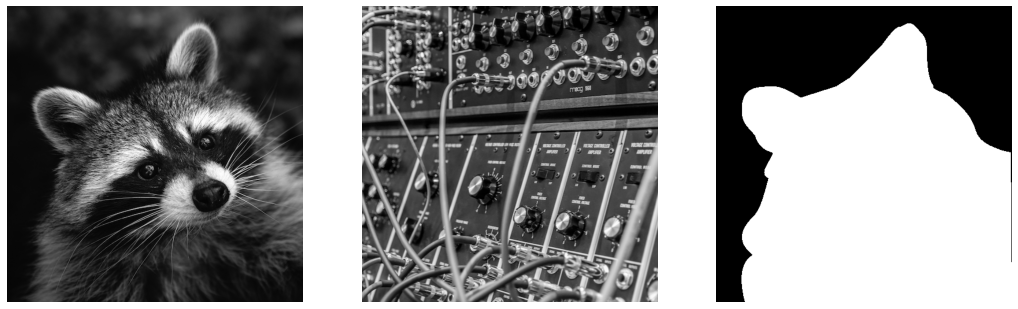

In [118]:
#-----------------------------------------------------------------------------
# get images
#-----------------------------------------------------------------------------
imgA = read_img('imgA.png')
imgA = cv2.cvtColor(src=imgA, code=cv2.COLOR_RGB2GRAY)
imgB = read_img('bkgnd.png')
imgB = cv2.cvtColor(src=imgB, code=cv2.COLOR_RGB2GRAY)

mask     = read_img('mask2.png')
mask     = cv2.cvtColor(src=mask, code=cv2.COLOR_RGB2GRAY)
ret,mask = cv2.threshold(mask,127,1,cv2.THRESH_BINARY)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
ax[0].imshow(imgA, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[0].set_axis_off()
ax[1].imshow(imgB, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[1].set_axis_off()
ax[2].imshow(mask, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[2].set_axis_off()
plt.show()

# Image stacks
Create the image stacks: Laplacian image stacks for imgA and imgB, Gaussian image stack for the mask.

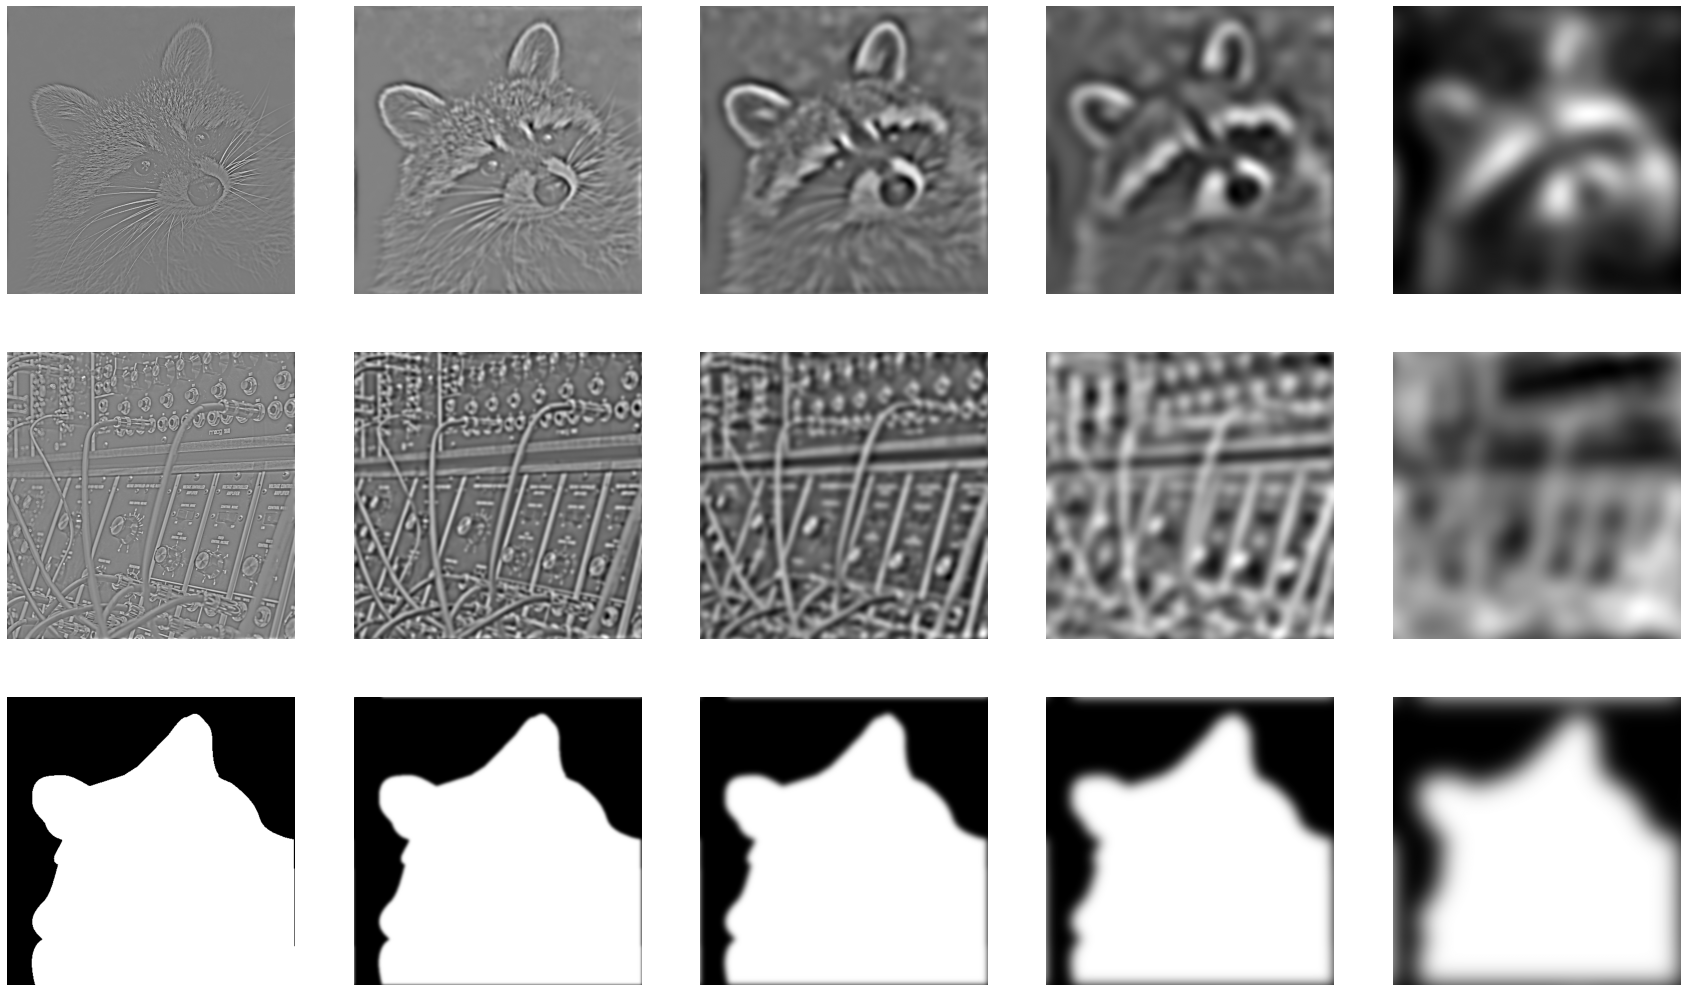

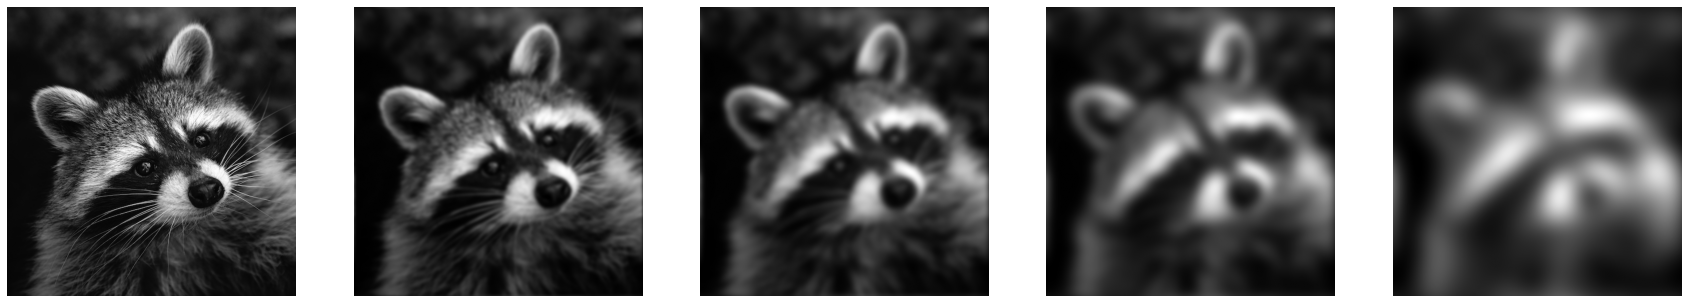

In [119]:
#-----------------------------------------------------------------------------
# Laplacian and Gaussian image stacks
#-----------------------------------------------------------------------------
sigmas = [32, 16, 8, 4]
imgAL  = stackLaplacian(imgA, sigmas)
imgBL  = stackLaplacian(imgB, sigmas)
maskG  = stackGaussian(mask, sigmas)

N = len(sigmas)+1
fig, ax = plt.subplots(nrows=3, ncols=N, figsize=(N*6,18))
for i in range(0,N):
    ax[0,i].imshow(imgAL[i], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
    ax[0,i].set_axis_off()
    ax[1,i].imshow(imgBL[i], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
    ax[1,i].set_axis_off()
    ax[2,i].imshow(maskG[i], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
    ax[2,i].set_axis_off()
plt.show()

imgAG = stackGaussian(imgA, sigmas)
N = len(sigmas)+1
fig, ax = plt.subplots(nrows=1, ncols=N, figsize=(N*6,18))
for i in range(0,N):
    ax[i].imshow(imgAG[i], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
    ax[i].set_axis_off()
plt.show()

# Image blending

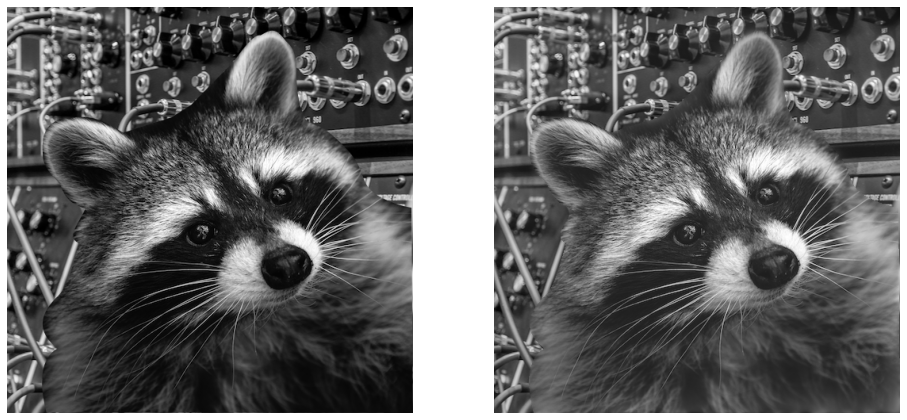

In [120]:
# cut and paste version
imgCP = read_img('racoon-cut-paste.png')
imgCP = cv2.cvtColor(src=imgCP, code=cv2.COLOR_RGB2GRAY)

# image blending version
wA   = [0.5, 0.5, 0.5, 0.5, 0.5]
wB   = [0.5, 0.5, 0.5, 0.5, 0.5]

imgC = img_blend(imgA, imgB, mask, wA, wB, sigmas)

#imgC = exposure.match_histograms(imgC, imgB)
#imgC = cv2.convertScaleAbs(imgC)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].imshow(imgCP, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[0].set_axis_off()
ax[1].imshow(imgC, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[1].set_axis_off()
plt.show()


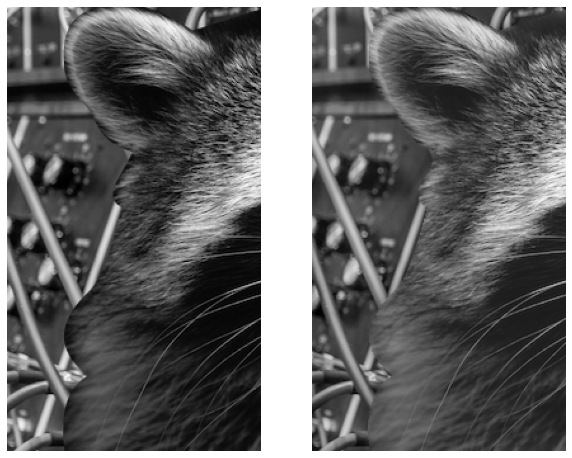

In [121]:
x = 0
y = 140
W = 200
H = 350
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
ax[0].imshow(imgCP[y:y+H, x:x+W], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[0].set_axis_off()
ax[1].imshow(imgC[y:y+H, x:x+W], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[1].set_axis_off()
plt.show()

# Summary

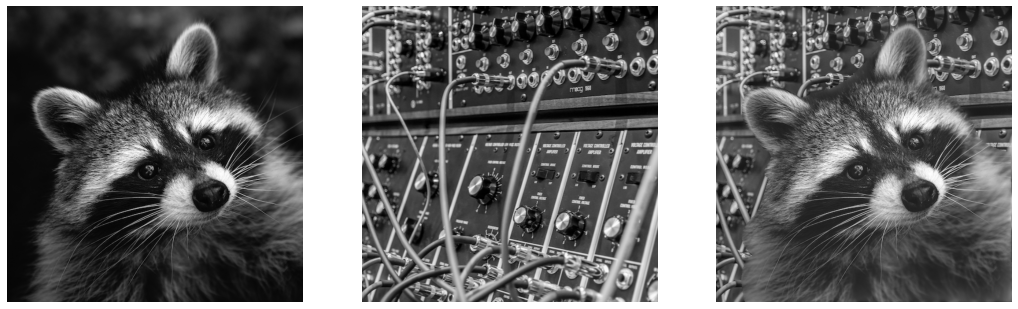

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
ax[0].imshow(imgA, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[0].set_axis_off()
ax[1].imshow(imgB, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[1].set_axis_off()
ax[2].imshow(imgC, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[2].set_axis_off()
plt.show()